In [1]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from prelim_experiments.param_experiments.chaney_utils import (
    load_sim_results,
    graph_relative_to_ideal,
    merge_results,
    graph_metrics,
    graph_metrics_by_axis,
    graph_relative_to_global_by_axis,
    transform_relative_to_global,
    graph_histogram_metric_by_axis,
    graph_averaged_metric_by_axis,
    graph_metrics_difference_by_axis,
    merge_diagnostics_results
)
from wrapper.models.bubble import BubbleBurster
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from prelim_experiments.param_experiments.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools
import os

from src.utils import user_topic_mapping as user_topic_mapping_func
from src.plotting import *

In [2]:
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

In [3]:
def plot_pca_3d(user_representation_df, n_clusters, title="Visualizing Clusters in Three Dimensions Using PCA"):
    pca = PCA(n_components=3)
    PCs_df = pd.DataFrame(pca.fit_transform(user_representation_df.drop(["Cluster"], axis=1)))
    PCs_df.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    
    plotX = pd.concat([user_representation_df, PCs_df], axis=1, join='inner')
    plotX["dummy"] = 0
    cluster_list = []
    for i in range(n_clusters):
        cluster_list.append(('clust_'+str(i), plotX[plotX["Cluster"] == i]))
    data = []
    for i in range(n_clusters):
        cluster = cluster_list[i]
        data.append(go.Scatter3d(
                        x = cluster[1]["PC1_3d"],
                        y = cluster[1]["PC2_3d"],
                        z = cluster[1]["PC3_3d"],
                        mode = "markers",
                        name = cluster[0],
                        text = None))

    title = title

    layout = dict(title = title,
                xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                )

    fig = dict(data = data, layout = layout)
    return fig


def plot_pca_3d_subplots(user_representation_df, n_clusters, title="Visualizing Clusters in Three Dimensions Using PCA"):
    pca = PCA(n_components=3)
    PCs_df = pd.DataFrame(pca.fit_transform(user_representation_df.drop(["Cluster"], axis=1)))
    PCs_df.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    
    plotX = pd.concat([user_representation_df, PCs_df], axis=1, join='inner')
    plotX["dummy"] = 0
    cluster_list = []
    for i in range(n_clusters):
        cluster_list.append(('clust_'+str(i), plotX[plotX["Cluster"] == i]))
    data = []
    for i in range(n_clusters):
        cluster = cluster_list[i]
        data.append(go.Scatter3d(
                        x = cluster[1]["PC1_3d"],
                        y = cluster[1]["PC2_3d"],
                        z = cluster[1]["PC3_3d"],
                        mode = "markers",
                        # name = cluster[0],
                        text = None))

    title = title

    layout = go.Layout(title = title,
                xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                )

    fig = go.Figure(data = data, layout = layout)
    return fig


def merge_diagnostics_results(folder_paths, file_names, diagnostics_vars=["mean", "std", "median", "min", "max", "skew"]):
    assert (len(folder_paths) == len(file_names)), "Must supply same number of folder paths and file names"
    model_diagnostics = defaultdict(lambda: defaultdict(list))
    final_diagnostics = defaultdict(lambda: defaultdict(list))
    for idx in range(len(folder_paths)):
        results = load_sim_results(folder_paths[idx], file_names[idx])
        
        for metric_name, model in results.items():
            for model_name, diagnostic in model.items():
                for diag, diag_vals in diagnostic.items():
                    model_diagnostics[metric_name][diag] = diag_vals 
                for metric in model_diagnostics:
                    final_diagnostics[metric][model_name] = model_diagnostics[metric]
    return final_diagnostics


def calculate_cluster_switch(user_to_item_cluster_assignment, final_user_pref_mapping, model):
    data = []
    data.append(user_to_item_cluster_assignment)
    data.append(final_user_pref_mapping)
    data = np.array(data).T
    cluster_changes_df = pd.DataFrame(data, columns=['initial_cluster', 'final_cluster'])
    cluster_changes_df = cluster_changes_df[cluster_changes_df['initial_cluster'] != cluster_changes_df['final_cluster']]
    print(model, ': Number of people who changed clusters: ', cluster_changes_df.shape[0])
    return cluster_changes_df.shape[0]
    
    
def plot_tsne_comparison(df1, df2, n_clusters, title1='Before Simulation', title2='After Simulation'):
    """
    Plots two tsne plots (before and after simulation) with convex hulls.
    Parameters
    ----------
    df : pd.DataFrame
    Dataframe with columns 'comp-1', 'comp-2' and 'y'
    perplexity : int
    Perplexity for tsne
    """
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))


    palette = sns.color_palette(cc.glasbey, n_colors=n_clusters)


    plot_clusters(df1, axs[0], palette)
    axs[0].set_title(title1)
    plot_clusters(df2, axs[1], palette, previously_seen=df1.y.unique())
    axs[1].set_title(title2)


    plt.suptitle(f'TSNE')
    plt.show()


In [4]:
results_paths = {
    'repeated_training': ['all_sim_results/user_pairs_via_user_clusters/15clusters/simulation1/repeated_training'],
    'single_training': ['all_sim_results/user_pairs_via_user_clusters/15clusters/simulation1/single_training']
}
num_sims = 1

environment_file = ["sim_environment.pkl"]

repeated_training_env = merge_results(results_paths['repeated_training'], environment_file)
single_training_env = merge_results(results_paths['single_training'], environment_file)

environments = {
    'repeated_training': repeated_training_env,
    'single_training': single_training_env
}

env_keys = list(repeated_training_env.keys())
model_keys = list(repeated_training_env[env_keys[0]].keys())

print(len(env_keys), env_keys)
print(len(model_keys), model_keys)

9 ['actual_user_representation_initial', 'actual_user_representation_final', 'user_cluster_assignments', 'user_cluster_centroids', 'item_representation', 'item_cluster_assignments', 'item_cluster_centroids', 'global_user_centroid', 'user_item_cluster_mapping']
9 ['baseline_myopic', 'repeated_items_repeat_interactions', 'probabilistic', 'random', 'random_interleaving', 'xquad_binary_0.1', 'xquad_binary_0.25', 'xquad_smooth_0.1', 'xquad_smooth_0.25']


In [5]:
# user_representation_initial = repeated_training_env['actual_user_representation_initial']
# user_representation_initial = list(user_representation_initial.values())[0][0]

# user_representation_final = repeated_training_env['actual_user_representation_final']
# user_representation_final = list(user_representation_final.values())[0][0]

In [6]:
# all_user_representation_final = {}

# for model in repeated_training_env['actual_user_representation_final'].keys():
#     all_user_representation_final[model] = repeated_training_env['actual_user_representation_final'][model][0]

# all_user_representation_final.keys()

# User representations by cluster

In [7]:
# # Repeated training

# n_clusters = 15

# initial_user_representation_df = pd.DataFrame(StandardScaler().fit_transform(user_representation_initial))
# initial_user_representation_df['Cluster'] = list(repeated_training_env['user_cluster_assignments'].values())[0][0]
# initial_fig = plot_pca_3d_subplots(initial_user_representation_df, n_clusters)

# final_rep_figs = []
# subplot_titles = ["initial"]
# for model in all_user_representation_final:
#     subplot_titles.append(model)
#     final_user_rep_df = pd.DataFrame(StandardScaler().fit_transform(all_user_representation_final[model]))
#     final_user_rep_df['Cluster'] = list(repeated_training_env['user_cluster_assignments'].values())[0][0]
#     final_rep_figs.append(plot_pca_3d_subplots(final_user_rep_df, n_clusters))

# # final_fig = plot_pca_3d_subplots(myopic_final_user_rep_df, n_clusters)

# num_rows, num_cols = 4, 3

# num_subplots = 9
# fig_results = make_subplots(
#     rows=num_rows, cols=num_cols,
#     subplot_titles=subplot_titles,
#     specs=[[{'type':'scene'}, None, None],
#            [{'type':'scene'}, {'type':'scene'}, {'type':'scene'}],
#            [{'type':'scene'}, {'type':'scene'}, {'type':'scene'}],
#            [{'type':'scene'}, {'type':'scene'}, {'type':'scene'}]],
#     horizontal_spacing = 0.1,
#     vertical_spacing = 0.1
# )

# # print(fig_results.print_grid)
# for d in initial_fig.data:
#     fig_results.add_trace(d, row=1, col=1)

# fig_idx = 0    
# for row in range(2, num_rows+1):
#     for col in range(1, num_cols+1):
#         for d in final_rep_figs[fig_idx].data:
#             fig_results.append_trace(d, row=row, col=col)
#         fig_idx += 1


# fig_results.layout.update(height=1500, width=1800, showlegend=False)    
# fig_results.show()


In [8]:
# # Single training v. Repeated training
# n_clusters = 15

# model_names = list(single_training_env['actual_user_representation_initial'].keys())
# plot_model = model_names[1]
# print(plot_model)

# curr_model_user_representation_final = {
#     "single_training":single_training_env['actual_user_representation_final'][plot_model][0],
#     "repeated_training":repeated_training_env['actual_user_representation_final'][plot_model][0],
# }

# user_cluster_assignments = repeated_training_env['user_cluster_assignments'][plot_model][0]
# assert(np.array_equal(user_cluster_assignments, single_training_env['user_cluster_assignments'][plot_model][0]))

# initial_user_representation_df = pd.DataFrame(StandardScaler().fit_transform(user_representation_initial))
# initial_user_representation_df['Cluster'] = user_cluster_assignments
# initial_fig = plot_pca_3d_subplots(initial_user_representation_df, n_clusters)

# final_user_rep_df = pd.DataFrame(StandardScaler().fit_transform(curr_model_user_representation_final["single_training"]))
# final_user_rep_df['Cluster'] = user_cluster_assignments
# final_single_training_fig = plot_pca_3d_subplots(final_user_rep_df, n_clusters)

# final_user_rep_df = pd.DataFrame(StandardScaler().fit_transform(curr_model_user_representation_final["repeated_training"]))
# final_user_rep_df['Cluster'] = user_cluster_assignments
# final_repeated_training_fig = plot_pca_3d_subplots(final_user_rep_df, n_clusters)

# fig_results = make_subplots(
#     rows=1, cols=3,
#     subplot_titles=['Initial user representation', 'Single training', 'Repeated training'],
#     specs=[[{'type':'scene'}, {'type':'scene'}, {'type':'scene'}]],
#     horizontal_spacing = 0.1,
#     vertical_spacing = 0.1
# )

# # print(fig_results.print_grid)
# for d in initial_fig.data:
#     fig_results.add_trace(d, row=1, col=1)
# for f1 in final_single_training_fig.data:
#     fig_results.add_trace(f1, row=1, col=2)
# for f2 in final_repeated_training_fig.data:
#     fig_results.add_trace(f2, row=1, col=3)


# # fig_results.layout.update(height=400, width=1000, showlegend=False, title_text=plot_model)  
# fig_results.layout.update(height=400, width=1000, title_text=plot_model)    
# fig_results.show()


In [9]:
env_keys_labels = [
    'actual_user_representation_initial',
    'actual_user_representation_final',
    'user_cluster_assignments_initial',
    'user_cluster_centroids',
    'item_representation',
    'item_cluster_assignments',
    'item_cluster_centroids',
    'global_user_centroid',
    'user_item_cluster_mapping_initial'
]

model_names_readable = {
    'baseline_myopic':'Myopic',
    'repeated_items_repeat_interactions':'repeated_items_repeat_interactions',
    'probabilistic':'Probabilistic',
    'random':'Random',
    'random_interleaving':'Random Interleaving',
    'xquad_binary_0.1': "Binary XquAD, alpha=0.1",
    'xquad_binary_0.25': "Binary XquAD, alpha=0.25",
    'xquad_smooth_0.1': "Smooth XquAD, alpha=0.1",
    'xquad_smooth_0.25': "Smooth XquAD, alpha=0.25"
}
training_readable = {
    'single':'Single',
    'repeated':'Repeated'
}

In [10]:

# plot_by = 'user_cluster'
# plot_by = 'user_topic'

# item_cluster_centers = environment['item_cluster_centroids'][model][0]
# user_topic_mapping = environment['user_item_cluster_mapping'][model][0]

# user_topic_mapping = {
#     'initial': environment['user_item_cluster_mapping'][model][0],
#     'final': user_topic_mapping_func(final_user_representation, item_cluster_centers)
# }
# user_cluster_assignments = {
#     'initial': environment['user_cluster_assignments'][model][0],
#     'final': user_topic_mapping_func(final_user_representation, user_cluster_centers)
# }

In [11]:

def plot_tsne_3_comparison(dfs, titles, fig_title, n_clusters):
    """
    Plots two tsne plots (before and after simulation) with convex hulls.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with columns 'comp-1', 'comp-2' and 'y'
    perplexity : int
        Perplexity for tsne
    """
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))

    palette = sns.color_palette(cc.glasbey, n_colors=n_clusters)

    plot_clusters(dfs[0], axs[0], palette)
    axs[0].set_title(titles[0])
    plot_clusters(dfs[1], axs[1], palette, previously_seen=dfs[1].y.unique())
    axs[1].set_title(titles[1])
    plot_clusters(dfs[2], axs[2], palette, previously_seen=dfs[2].y.unique())
    axs[2].set_title(titles[2])

    plt.suptitle(fig_title)
    plt.show()

In [12]:
# clustering_df = pd.DataFrame(columns=['Model', 'Training type', 'No. initial user communities ', 'No. final user communities', 'No. user community switches', 'No. initial user-topic clusters', 'No. final user-topic clusters', 'No. user-topic cluster switches'])
# # display(clustering_df.head())

# model_names_readable = {
#     'baseline_myopic':'Myopic',
#     'repeated_items_repeat_interactions':'repeated_items_repeat_interactions',
#     'probabilistic':'Probabilistic',
#     'random':'Random',
#     'random_interleaving':'Random Interleaving',
#     'xquad_binary_0.1': "Binary XquAD, alpha=0.1",
#     'xquad_binary_0.25': "Binary XquAD, alpha=0.25",
#     'xquad_smooth_0.1': "Smooth XquAD, alpha=0.1",
#     'xquad_smooth_0.25': "Smooth XquAD, alpha=0.25"
# }
# training_readable = {
#     'single':'Single',
#     'repeated':'Repeated'
# }

# for model in model_keys:

#     model_single = dict(zip(env_keys_labels, [environments['single_training'][env_k][model][0] for env_k in env_keys]))
#     model_single['user_item_cluster_mapping_final'] = user_topic_mapping_func(model_single['actual_user_representation_final'], model_single['item_cluster_centroids'])
#     model_single['user_cluster_assignments_final'] = user_topic_mapping_func(model_single['actual_user_representation_final'], model_single['user_cluster_centroids'])

#     model_repeated = dict(zip(env_keys_labels, [environments['repeated_training'][env_k][model][0] for env_k in env_keys]))
#     model_repeated['user_item_cluster_mapping_final'] = user_topic_mapping_func(model_repeated['actual_user_representation_final'], model_repeated['item_cluster_centroids'])
#     model_repeated['user_cluster_assignments_final'] = user_topic_mapping_func(model_repeated['actual_user_representation_final'], model_repeated['user_cluster_centroids'])

#     curr_model = {
#         'single': model_single,
#         'repeated': model_repeated
#     }

#     for model_name, model_ in curr_model.items():
#         print(f"\n{model}, {model_name}")
#         data = [model_names_readable[model], training_readable[model_name]]
        
#         # print("No. of initial user communities represented\n\t=", np.unique(model_['user_cluster_assignments_initial']).size)
#         data.append(np.unique(model_['user_cluster_assignments_initial']).size)
#         # print("No. of final user communities represented\n\t=", np.unique(model_['user_cluster_assignments_final']).size)
#         data.append(np.unique(model_['user_cluster_assignments_final']).size)
#         data.append(calculate_cluster_switch(model_['user_cluster_assignments_initial'], model_['user_cluster_assignments_final'], f"{model}, repeated training"))
        
#         # print("No. of initial user-topic clusters represented\n\t=", np.unique(model_['user_item_cluster_mapping_initial']).size)
#         data.append(np.unique(model_['user_item_cluster_mapping_initial']).size)
#         # print("No. of final user-topic clusters represented\n\t=", np.unique(model_['user_item_cluster_mapping_final']).size)
#         data.append(np.unique(model_['user_item_cluster_mapping_final']).size)
#         data.append(calculate_cluster_switch(model_['user_item_cluster_mapping_initial'], model_['user_item_cluster_mapping_final'], f"{model}, single training"))
        
#         # print(len(data))
#         clustering_df.loc[len(clustering_df.index)] = data

# # clustering_df.head()
        

In [23]:
model = model_keys[0]
print(model)

model_single = dict(zip(env_keys_labels, [environments['single_training'][env_k][model][0] for env_k in env_keys]))
model_single['user_item_cluster_mapping_final'] = user_topic_mapping_func(model_single['actual_user_representation_final'], model_single['item_cluster_centroids'])
model_single['user_cluster_assignments_final'] = user_topic_mapping_func(model_single['actual_user_representation_final'], model_single['user_cluster_centroids'])

model_repeated = dict(zip(env_keys_labels, [environments['repeated_training'][env_k][model][0] for env_k in env_keys]))
model_repeated['user_item_cluster_mapping_final'] = user_topic_mapping_func(model_repeated['actual_user_representation_final'], model_repeated['item_cluster_centroids'])
model_repeated['user_cluster_assignments_final'] = user_topic_mapping_func(model_repeated['actual_user_representation_final'], model_repeated['user_cluster_centroids'])

curr_model = {
    'name':model,
    'single': model_single,
    'repeated': model_repeated
}

perplexity = 50
n_clusters = 15

baseline_myopic


baseline_myopic
Difference between user cluster assignment initial v. user cluster assignment final


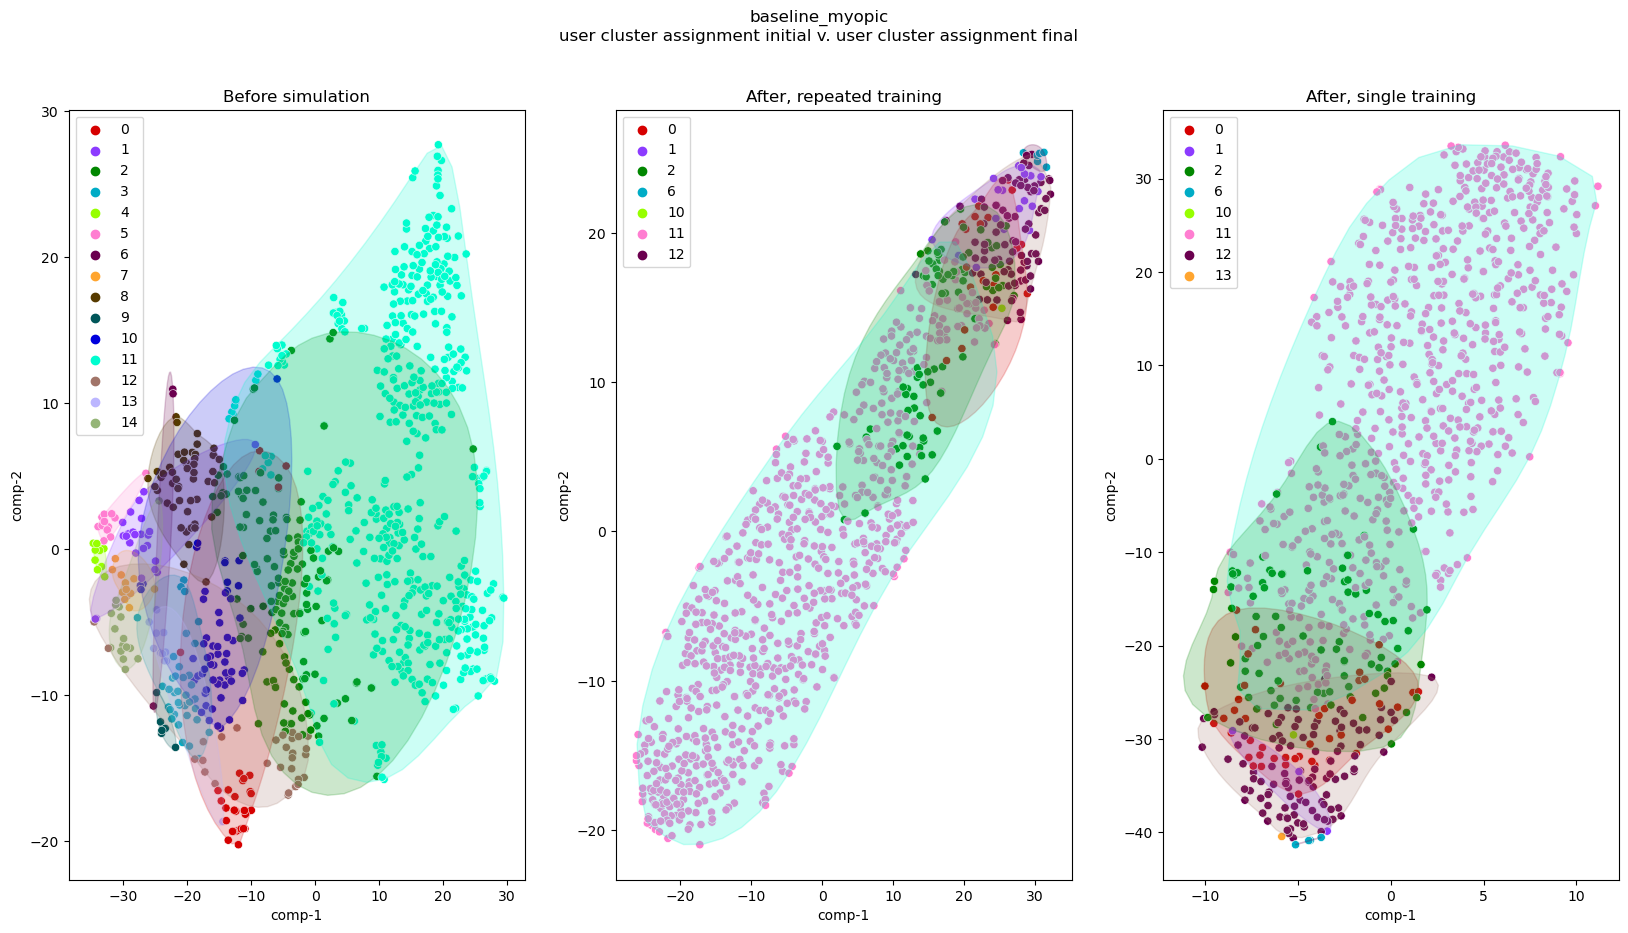

Myopic, repeated training : Number of people who changed clusters:  437
baseline_myopic, single training : Number of people who changed clusters:  434


In [24]:
"""
Difference between user cluster assignment initial v. user cluster assignment final
"""

print(curr_model['name'])
plot_by = 'user_cluster'

if plot_by == 'user_cluster':
    print("Difference between user cluster assignment initial v. user cluster assignment final")
    df_prev = apply_tsne_2d(curr_model['repeated']['actual_user_representation_initial'], curr_model['repeated']['user_cluster_assignments_initial'], perplexity=perplexity)
    df_rep_post = apply_tsne_2d(curr_model['repeated']['actual_user_representation_final'], curr_model['repeated']['user_cluster_assignments_final'], perplexity=perplexity)
    df_sing_post = apply_tsne_2d(curr_model['single']['actual_user_representation_final'], curr_model['single']['user_cluster_assignments_final'], perplexity=perplexity)
    
    # if np.unique(plot_model['user_cluster_assignments_final']).size < plot_model['user_cluster_assignments_initial'].size:
    #     plot_tsne_comparison(df_post, df_prev, n_clusters, "After simulation", 'Before simulation')
    # else:
    plot_tsne_3_comparison([df_prev, df_rep_post, df_sing_post], ['Before simulation', 'After, repeated training', 'After, single training'], f"{model}\nuser cluster assignment initial v. user cluster assignment final", n_clusters)
        
    calculate_cluster_switch(curr_model['repeated']['user_cluster_assignments_initial'], curr_model['repeated']['user_cluster_assignments_final'], f"{model_names_readable[model]}, repeated training")
    calculate_cluster_switch(curr_model['single']['user_cluster_assignments_initial'], curr_model['single']['user_cluster_assignments_final'], f"{model}, single training")

Difference between user-topic mapping initial v. user-topic mapping final


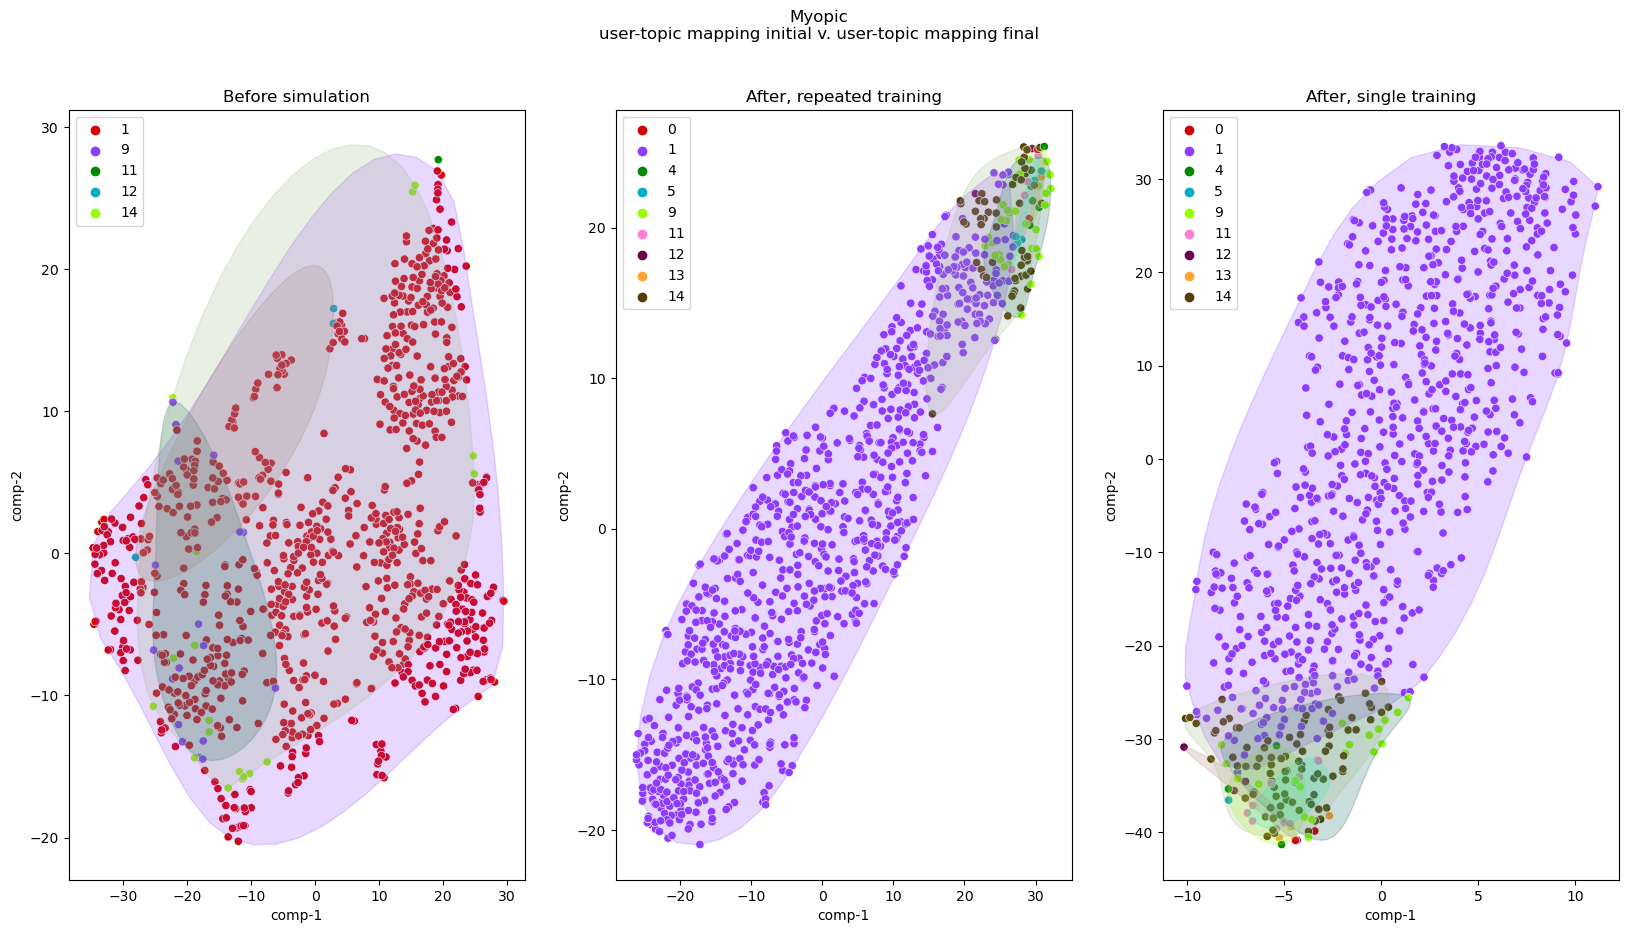

baseline_myopic, repeated training : Number of people who changed clusters:  128
baseline_myopic, single training : Number of people who changed clusters:  149


In [25]:
"""
Difference between user cluster assignment initial v. user cluster assignment final
"""

plot_by = 'user_topic'

if plot_by == 'user_topic':
    print("Difference between user-topic mapping initial v. user-topic mapping final")
    df_prev = apply_tsne_2d(curr_model['repeated']['actual_user_representation_initial'], curr_model['repeated']['user_item_cluster_mapping_initial'], perplexity=perplexity)
    df_rep_post = apply_tsne_2d(curr_model['repeated']['actual_user_representation_final'], curr_model['repeated']['user_item_cluster_mapping_final'], perplexity=perplexity)
    df_sing_post = apply_tsne_2d(curr_model['single']['actual_user_representation_final'], curr_model['single']['user_item_cluster_mapping_final'], perplexity=perplexity)
    
    plot_tsne_3_comparison([df_prev, df_rep_post, df_sing_post], ['Before simulation', 'After, repeated training', 'After, single training'], f"{model_names_readable[model]}\nuser-topic mapping initial v. user-topic mapping final", n_clusters)
        
    calculate_cluster_switch(curr_model['repeated']['user_item_cluster_mapping_initial'], curr_model['repeated']['user_item_cluster_mapping_final'], f"{model}, repeated training")
    calculate_cluster_switch(curr_model['single']['user_item_cluster_mapping_initial'], curr_model['single']['user_item_cluster_mapping_final'], f"{model}, single training")

# Distance user-cluster distance distribution 

In [16]:
# results_paths = {
#     'repeated_training': ['all_sim_results/user_pairs_via_user_clusters/15clusters/simulation1/repeated_training'],
#     'single_training': ['all_sim_results/user_pairs_via_user_clusters/15clusters/simulation1/single_training']
# }
# num_sims = 1

# results_file = ["sim_results.pkl"]

# repeated_training_results = merge_results(results_paths['repeated_training'], results_file)
# single_training_results = merge_results(results_paths['single_training'], results_file)

# results = {
#     'single_training':single_training_results,
#     'repeated_training':repeated_training_results
# }

# metric_keys = list(repeated_training_results.keys())
# model_keys = list(repeated_training_results[metric_keys[0]].keys())
# num_timesteps = len(repeated_training_results[metric_keys[0]][model_keys[0]][0])

# print(len(metric_keys), metric_keys)
# print(len(model_keys), model_keys)
# print("No. timesteps =", num_timesteps)

# num_users = 943

In [17]:
# """
# Difference between user cluster assignment initial v. user cluster assignment final
# """

# model = model_keys[1]
# print(model)

# training_types = ['single_training', 'repeated_training']

# df = pd.DataFrame()
# # display(df.head())

# col_names = [f"t_{i+1}" for i in range(num_timesteps)]

# for training in training_types:
#     model_env = dict([(k, environments[training][k][model][0]) for k in env_keys])
#     user_dist = results[training]['user_distance_from_cluster_centroid'][model][0]
#     df_user_clust_dist = pd.DataFrame.from_dict(dict(zip(col_names, user_dist)))
#     df_user_clust_dist['user_id'] = np.arange(num_users)
#     if training == 'single_training':
#         df_user_clust_dist['repeated_training'] = np.full(num_users, 0)
#     else:
#         df_user_clust_dist['repeated_training'] = np.full(num_users, 1)
#     df_user_clust_dist['initial_cluster'] = model_env['user_cluster_assignments']
#     df_user_clust_dist['final_cluster']  = user_topic_mapping_func(model_env['actual_user_representation_final'], model_env['user_cluster_centroids'])
    
#     df = pd.concat([df, df_user_clust_dist], axis=0)

In [18]:
# timestep = 1
# num_clusters = 15

# clust_counts_initial = []
# clust_counts_final = []

# df_melted = pd.melt(frame = df,
#              id_vars = ['user_id', f"t_{timestep}"],
#              value_vars = ['initial_cluster', 'final_cluster'],
#              var_name = 'cluster_type',
#              value_name = 'cluster_id')

# df_melted
# # df['value'] = df['value'].astype(float)

# fig, ax = plt.subplots(figsize=(15, 8))

# sns.violinplot(ax = ax,
#                data = df_melted,
#                x = 'cluster_id',
#                y = f"t_{timestep}",
#                hue = 'cluster_type',
#                split = True)

# plt.show()


In [19]:
# def generate_cluster_stats_df(df, num_clusts=15, name=''):
#     result_df = pd.DataFrame(columns=['Cluster ID', 'No. initial users', 'Initial mean distance', 'Initial SD', 'No. final users', 'Final mean distance', 'Final SD'])
#     result_df.name = name
    
#     for clust_id in range(num_clusts):
#         # print(df[df.initial_cluster == clust_id].shape[0])
#         data = [
#             clust_id,
#             df[df.initial_cluster == clust_id].shape[0],
#             df[df.initial_cluster == clust_id]['t_1'].mean(),
#             df[df.initial_cluster == clust_id]['t_1'].std(),
#             df[df.final_cluster == clust_id].shape[0],
#             df[df.final_cluster == clust_id]['t_100'].mean(),
#             df[df.final_cluster == clust_id]['t_100'].std()
#         ]
#         result_df.loc[len(result_df.index)] = data
        
#     return result_df


# # print(f"Cluster {cluster_id} - User Cluster Stats")

# # print(f"\nInitial cluster\n\t# users = {df[df.initial_cluster == clust_id].shape[0]}")
# # print(f"\n\tMean distance = {df[df.initial_cluster == clust_id]['t_1'].mean()}")
# # print(f"\n\tSD = {df[df.initial_cluster == clust_id]['t_1'].std()}")

# # print(f"Final cluster, # users = {df[df.final_cluster == clust_id].shape[0]}")
# # print(f"\n\tMean distance = {df[df.final_cluster == clust_id]['t_100'].mean()}")
# # print(f"\n\tSD distance = {df[df.final_cluster == clust_id]['t_100'].std()}")

In [20]:
# res = generate_cluster_stats_df(df, num_clusts=15, name=f"Distance from user embedding to cluster centroid - {model_names_readable[model]}")
# print(res.name)
# res

In [21]:
# fig = go.Figure()

# t_initial, t_final = 1, 100

# cluster_ids = [c for c in range(num_clusters)]
# for clust_id in cluster_ids:
#     # Plotting distribution of INITIAL user distance to INITIAL cluster by cluster
#     # clust_counts_initial.append((clust_id, df[df.initial_cluster == clust_id].shape[0]))
#     fig.add_trace(go.Violin(x=df['initial_cluster'][df['initial_cluster'] == clust_id],
#                             y=df[f"t_{t_initial}"][df['initial_cluster'] == clust_id],
#                             legendgroup=f"Initial",
#                             name='Initial user cluster assignment',
#                             box_visible=True,
#                             line_color='lightseagreen',
#                             meanline_visible=True,
#                             showlegend=(clust_id==0),
#                             text=f"{df[df.initial_cluster == clust_id].shape[0]} users"
#                             ))
#     # Plotting distribution of FINAL user distance to FINAL cluster 
#     # clust_counts_final.append((clust_id, df[df.final_cluster == clust_id].shape[0]))
#     fig.add_trace(go.Violin(x=df['final_cluster'][df['final_cluster'] == clust_id],
#                             y=df[f"t_{t_final}"][df['final_cluster'] == clust_id],
#                             legendgroup='Final',
#                             name=f"Final user cluster assignment",
#                             box_visible=True,
#                             line_color='mediumpurple',
#                             meanline_visible=True,
#                             showlegend=(clust_id==0)
#                             ))
# # fig.update_layout(violinmode='group')
# fig.update_layout(
#     title=f"Distance from user embedding to cluster centroid - {model_names_readable[model]}",
#     xaxis_title="Cluster ID",
#     yaxis_title="Distance",
#     # legend_title="Cluster assignment before v. after ",
#     xaxis = dict(ticktext=cluster_ids, tick0=0, dtick=1),
#     # legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
# )
# fig.show()

In [22]:
# # initial_clusts = list(df['initial_cluster'].value_counts())
# # initial_clusts



# clust_counts = df['initial_cluster'].value_counts()
# initial_clust_counts = {c: 0 for c in range(num_clusters)}
# initial_clust_counts.update(dict(zip(clust_counts.index, clust_counts.values)))

# clust_counts = df['final_cluster'].value_counts()
# final_clust_counts = {c: 0 for c in range(num_clusters)}
# final_clust_counts.update(dict(zip(clust_counts.index, clust_counts.values)))

# for k in range(num_clusters):
#     print(f"Cluster {k}\n\tinitial={initial_clust_counts[k]}\n\tfinal={final_clust_counts[k]}")